### Student Information
Name:  李博業

Student ID: 410978058

GitHub ID: BORYA-dev

Kaggle name: borya lee

Kaggle private scoreboard snapshot:

---

### Instructions

1. First: __This part is worth 30% of your grade.__ Do the **take home exercises** in the [DM2024-Lab2-master Repo](https://github.com/didiersalazar/DM2024-Lab2-Master). You may need to copy some cells from the Lab notebook to this notebook.


2. Second: __This part is worth 30% of your grade.__ Participate in the in-class [Kaggle Competition](https://www.kaggle.com/competitions/dm-2024-isa-5810-lab-2-homework) regarding Emotion Recognition on Twitter by this link: https://www.kaggle.com/competitions/dm-2024-isa-5810-lab-2-homework. The scoring will be given according to your place in the Private Leaderboard ranking:
    - **Bottom 40%**: Get 20% of the 30% available for this section.

    - **Top 41% - 100%**: Get (0.6N + 1 - x) / (0.6N) * 10 + 20 points, where N is the total number of participants, and x is your rank. (ie. If there are 100 participants and you rank 3rd your score will be (0.6 * 100 + 1 - 3) / (0.6 * 100) * 10 + 20 = 29.67% out of 30%.)   
    Submit your last submission **BEFORE the deadline (Nov. 26th, 11:59 pm, Tuesday)**. Make sure to take a screenshot of your position at the end of the competition and store it as '''pic0.png''' under the **img** folder of this repository and rerun the cell **Student Information**.
    

3. Third: __This part is worth 30% of your grade.__ A report of your work developing the model for the competition (You can use code and comment on it). This report should include what your preprocessing steps, the feature engineering steps and an explanation of your model. You can also mention different things you tried and insights you gained.


4. Fourth: __This part is worth 10% of your grade.__ It's hard for us to follow if your code is messy :'(, so please **tidy up your notebook**.


Upload your files to your repository then submit the link to it on the corresponding e-learn assignment.

Make sure to commit and save your changes to your repository __BEFORE the deadline (Nov. 26th, 11:59 pm, Tuesday)__.

- emotion
  - The emotion(answer) of data
    - sadness
    - disgust
    - anticipation
    - joy
    - trust
    - anger
    - fear
    - surprise

- data_identification :
  - identify the id is train or test
  
- tweets_DM.json : Main Data
  - type : list
  - length = 1867535
  - record :
    {
    '_score': 391,
    '_index': 'hashtag_tweets',
    '_source': {'tweet': {'hashtags': ['Snapchat'],
      'tweet_id': '0x376b20',
      'text': 'People who post "add me on #Snapchat" must be dehydrated. Cuz man.... that\'s <LH>'}},
    '_crawldate': '2015-05-23 11:42:47',
    '_type': 'tweets'
    }

In [8]:
import pandas as pd
import numpy as np
import json
from sklearn.model_selection import train_test_split

import nltk
import re
import stringprep
nltk.download('punkt_tab')
# nltk.download('wordnet')


import matplotlib.pyplot as plt

import pickle

# Random Forest
from sklearn.ensemble import RandomForestClassifier

# TF-IDF
from sklearn.feature_extraction.text import TfidfVectorizer


from sklearn.metrics import accuracy_score

# NN
import keras
from keras.models import Model
from keras.layers import Input, Dense
from keras.layers import ReLU, Softmax
from sklearn.preprocessing import LabelEncoder


## BERT Embedding + Fine Tuning

import torch
from transformers import BertTokenizer, BertForSequenceClassification
from torch.utils.data import Dataset,DataLoader
from tqdm.auto import tqdm
import torch.utils.data as data

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [6]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


- Prepare Data

In [7]:
### Begin Assignment Here

# 準備資料

file_path = '/content/drive/MyDrive/Data_Lab2_HW/tweets_DM.json'

data = []

with open(file_path, 'r', encoding='utf-8') as file:
    for line_number, line in enumerate(file, start=1):
        try:
            data.append(json.loads(line))
        except json.JSONDecodeError as e:
            print(f"Error in line {line_number}: {e}")


emotion_data = pd.read_csv('/content/drive/MyDrive/Data_Lab2_HW/emotion.csv')
data_id = pd.read_csv('/content/drive/MyDrive/Data_Lab2_HW/data_identification.csv')

# 生成DataFrame

temp = []
for sub_d in data:
  temp.append(sub_d['_source']['tweet'])
data_df = pd.DataFrame(temp)


data_df = data_df.merge(data_id, on = "tweet_id", how="left")
data_df = data_df.merge(emotion_data, on = "tweet_id", how = "left")

data_df.head(5)


# 訓練集、測試集

training_data = data_df.query("identification == 'train'").reset_index(drop =True)
testing_data = data_df.query("identification == 'test'").reset_index(drop =True)

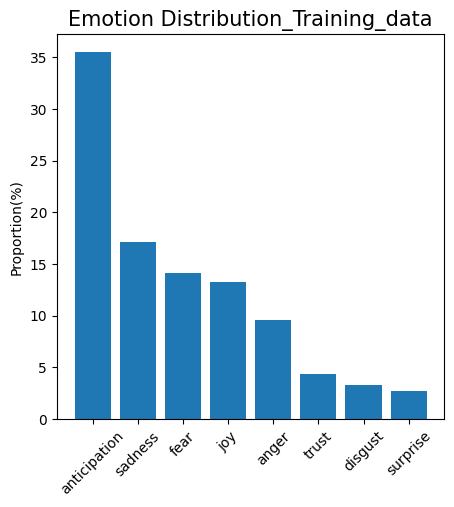

In [22]:
plt.figure(figsize = [5,5])

temp = training_data.emotion.value_counts().values

plt.bar(training_data.emotion.unique(), temp*100/temp.sum())

plt.xticks(size = 10, rotation = 45)
plt.title("Emotion Distribution_Training_data", size = 15)
plt.ylabel("Proportion(%)", size = 10)

plt.show()

- **Sample**

Due to vast amount of data and the issue of data imbalance, it is necessary to sample a subset of the data for analysis. I experimented with two sampling methods:

1. To address the imbalance problem, I sampled an equal number of data points from each category, using the category with the smallest number of samples as the reference.

2. Sample 25% of original data in advance, then strafied sampling to keep original distribution.

<ipython-input-29-20a6dce663a0>:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sampled_training = training_data.groupby('emotion').apply(lambda x: x.sample(n=min_class_num, random_state = 42) )


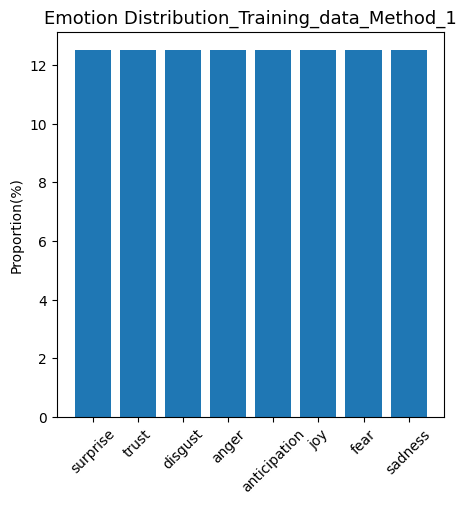

In [29]:
# Method_1. 抽等量

min_class_num = training_data.emotion.value_counts().min()

# 訓練集抽樣
sampled_training = training_data.groupby('emotion').apply(lambda x: x.sample(n=min_class_num, random_state = 42) )
sampled_training = sampled_training.reset_index(drop=True)
x_train = sampled_training.drop(columns = "emotion")
y_train = sampled_training.emotion


# # 分層抽樣
# # Strafied sampling

x_train, x_test, y_train, y_test = train_test_split(
    x_train, y_train, test_size=0.2, random_state=42, stratify=y_train
)

x_train.reset_index(drop=True, inplace = True)
y_train.reset_index(drop=True, inplace = True)
x_test.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)


plt.figure(figsize = [5,5])

temp = y_train.value_counts().values

plt.bar(y_train.unique(), temp*100/temp.sum())

plt.xticks(size = 10, rotation = 45)
plt.title("Emotion Distribution_Training_data_Method_1", size = 13)
plt.ylabel("Proportion(%)", size = 10)

plt.show()


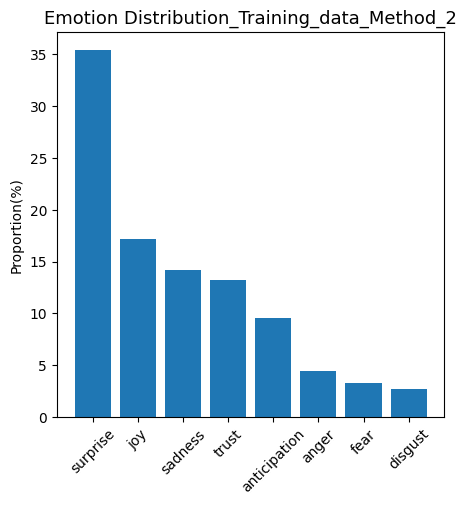

In [31]:
# Method_2. 分層抽樣
# 2. Strafied Sampling

train_data_sample = training_data.sample(frac=0.25, random_state=20)
train_data_sample = train_data_sample.reset_index(drop=True)

x_train = train_data_sample.drop(columns = ["emotion", "identification"])
y_train = train_data_sample.emotion

x_train, x_test, y_train, y_test = train_test_split(
    x_train, y_train, test_size=0.2, random_state=20, stratify=y_train
)

x_train.reset_index(drop=True, inplace = True)
y_train.reset_index(drop=True, inplace = True)
x_test.reset_index(drop=True, inplace = True)
y_test.reset_index(drop=True, inplace = True)


plt.figure(figsize = [5,5])

temp = y_train.value_counts().values

plt.bar(y_train.unique(), temp*100/temp.sum())

plt.xticks(size = 10, rotation = 45)
plt.title("Emotion Distribution_Training_data_Method_2", size = 13)
plt.ylabel("Proportion(%)", size = 10)

plt.show()

- Pre-processing
  1. Emoji Transformation
  2. Cleaning
    - Change into lower case
    - Remove stopping words, links, blank space
  3. Stemming & Lemmatization
  4. Tokenization
    

In [32]:
emoji_dict = {
    '😂': '[joy]',
    '❤️': '[love]',
    '😍': '[adoration]',
    '😭': '[cry]',
    '❤': '[care]',
    '😊': '[happy]',
    '🙏': '[pray]',
    '😘': '[kiss]',
    '💕': '[love_each_other]',
    '🔥': '[fire]',
    '😩': '[weary]',
    '🤔': '[think]',
    '💯': '[perfect]',
    '💙': '[loyalty]',
    '🙄': '[annoyed]',
    '😁': '[happy]',
    '🙌': '[celebrate]',
    '🙏🏾': '[pray]',
    '👍': '[approve]',
    '🙏🏽': '[pray]',
    '♡':'[love]',
    '🕘':'[time]',
    '🙋':'[hi]',
    '😃': '[smile]'
}

In [33]:
# emoji

def trans_emoji(text):
  for key, value in emoji_dict.items():
    text = text.replace(key, value)
  return text

def cleaning(text):

    text = text.replace("<lh>", "")
    text = text.replace("<LH>", "")

    text = trans_emoji(text)

    text = re.sub(r'[@#$%^&*()_+{}[\]:;"\'<>,.~\\/\-|=]', '', text)

    # remove some common words
    text = re.sub(r'\b(?:and|is|in|the|on|of|to|for)\b', '', text, flags=re.IGNORECASE)
    # remove numbers
    text = re.sub(r'\b\d+\b', '', text)
    # remove blank space
    text = re.sub(r'\s+', ' ', text).strip() # \s+ 一個或多個空白字符
    # remove links
    text = re.sub('((www.[^s]+)|(https?://[^s]+))',' ',text)
    return text



# Stemming
# st = nltk.PorterStemmer()

# def stemming_on_text(data):
#     '''
#     input should be tokenized words : list
#     '''
#     text = [st.stem(word) for word in data]
#     return text

# # Lemmatization
# lm = nltk.WordNetLemmatizer()
# def lemmatizer_on_text(data):
#     text = [lm.lemmatize(word) for word in data]
#     return text


def pre_processing(data):

  '''
  data:DataFrame with text
  '''

  dataset = data['text']


  # 轉小寫
  dataset = dataset.apply(lambda text: text.lower().strip())

  # 移除 removing

  # original tokens
  only_tokens = dataset.apply(lambda x: nltk.word_tokenize(x) )
  only_tokens.name = "tokens"

  # cleaning
  dataset = dataset.apply(lambda x: cleaning(x) )
  dataset.name = "pre_processing_text"

  # cleaning + tokens
  tt = dataset.apply(lambda x: nltk.word_tokenize(x))
  tt.name = "pre_processing_tokens"


  pre_df = pd.concat([pd.DataFrame(only_tokens), pd.DataFrame(dataset),pd.DataFrame(tt)], axis=1)

  return pre_df

In [ ]:
# Combine columns with pro-processing & original text

x_train = pd.concat([x_train, pre_processing(x_train)], axis=1)
x_train.reset_index(drop=True, inplace=True)

x_test = pd.concat([x_test, pre_processing(x_test)], axis=1)
x_test.reset_index(drop=True, inplace=True)

testing_data = pd.concat([testing_data, pre_processing(testing_data)], axis=1)
testing_data.reset_index(drop=True, inplace=True)

In [ ]:
x_train.head(5)

# tokens : tokenize without pre-processing
# pre_processing_text : pre_processing text
# pre_processing_text_tokens : tokenize with pre-processing

,hashtags,tweet_id,text,tokens,pre_processing_text,pre_processing_tokens
0,[God],0x231c61,Not the ones that want commitment... patiently...,"[not, the, ones, that, want, commitment, ..., ...",not ones that want commitment patiently waitin...,"[not, ones, that, want, commitment, patiently,..."
1,"[everyday, special]",0x330e2f,31 Push the <LH> #everyday. Be some #special. ...,"[31, push, the, <, lh, >, #, everyday, ., be, ...",push everyday be some special august at 0515pm,"[push, everyday, be, some, special, august, at..."
2,[],0x30eca8,@AADaddario @lotstar @michaellonghair loved to...,"[@, aadaddario, @, lotstar, @, michaellonghair...",aadaddario lotstar michaellonghair loved watch...,"[aadaddario, lotstar, michaellonghair, loved, ..."
3,"[payforplay, thatmeansyou, scum]",0x20e851,I AM IN <LH> THAT MEANS Y O U P A Y M E FOR AN...,"[i, am, in, <, lh, >, that, means, y, o, u, p,...",i am that means y o u p a y m e any servise i ...,"[i, am, that, means, y, o, u, p, a, y, m, e, a..."
4,[],0x254bff,Father God you are faithful. Be Lord of my lif...,"[father, god, you, are, faithful, ., be, lord,...",father god you are faithful be lord my life today,"[father, god, you, are, faithful, be, lord, my..."


- Embedding
  - TF-IDF
  - Word2Vec

- Model
  - Random Forest
  - NN

- BERT Fine Tune

In [ ]:
# TFIDF

# tweet_tokenizer = nltk.tokenize.TweetTokenizer() # 本來有用 max_df=0.9, tokenizer = tweet_tokenizer.tokenize
TF_IDF_vectorizer = TfidfVectorizer(max_features=1000) # 3000 2500 2000 都會爆
output_vectorizer = TF_IDF_vectorizer.fit_transform(x_train.text.values)  # fit + transform

output_vectorizer_test = TF_IDF_vectorizer.transform(x_test.text.values)  # only transform

output_vectorizer_true_test = TF_IDF_vectorizer.transform(testing_data.text.values)  # only transform

In [ ]:
# Random Forest

model = RandomForestClassifier()

## training !

DT_model = model.fit(output_vectorizer, y_train)

In [ ]:
## Training Accuracy

y_train_pred = DT_model.predict(output_vectorizer)

acc_train = accuracy_score(y_true=y_train, y_pred=y_train_pred)

print('training accuracy: {}'.format(round(acc_train, 2)))

training accuracy: 0.96


In [ ]:
# Mini-Testing

# Predict Mini-Testing (by Random Forest)

y_test_result = DT_model.predict( output_vectorizer_test )

acc_train = accuracy_score(y_true= y_test, y_pred= y_test_result)

print('Mini-testing accuracy: {}'.format(round(acc_train, 2)))

Mini-testing accuracy: 0.41


In [ ]:
# Output result

y_test_result = DT_model.predict( output_vectorizer_true_test )

result = pd.DataFrame( {
   "id" : testing_data.tweet_id,
   "emotion" : y_test_result
} )
result.to_csv("/content/drive/MyDrive/submission_test_v9.csv", index = 0)
result.head(5)

,id,emotion
0,0x1c7f0f,disgust
1,0x1c7f12,anger
2,0x1c7f13,trust
3,0x1c7f17,trust
4,0x1c7f18,anger


- Word2Vec + Random Forest

In [ ]:
# Training Word2Vec

from gensim.models import Word2Vec


train_corpus = x_train.pre_processing_tokens.values


# setting
vector_dim = 100
window_size = 5
min_count = 1
workers = 2

word2vec_model = Word2Vec(sentences=train_corpus,
              vector_size = vector_dim,
              window=window_size,
              min_count=min_count,
              workers = workers)

In [ ]:
def mean_word2vec(text_list):

  '''
  output is the mean of the input sentence.
  '''

  result = np.zeros(vector_dim, dtype = np.float64)
  len = 0
  for i in text_list:
    if i in word2vec_model.wv:
      result = result + word2vec_model.wv[i]
      len = len + 1

  return result/len if len != 0 else  result

In [ ]:
x_train["word2vec_100"] = x_train.apply(lambda x: mean_word2vec(x['tokens']), axis = 1)
x_test["word2vec_100"] = x_test.apply(lambda x: mean_word2vec(x['tokens']), axis = 1)
testing_data["word2vec_100"] = testing_data.apply(lambda x: mean_word2vec(x['tokens']), axis = 1)

In [ ]:
# LABEL Y
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.transform(y_test)

In [ ]:
# Training Random Forest

X = list(x_train.word2vec_100.values)

model = RandomForestClassifier()

## training!
DT_model = model.fit(X, y_train_encoded)

In [ ]:
## Testing Accuracy

x_test["word2vec_100"] = x_test.apply(lambda x: mean_word2vec(x['tokens']), axis = 1)
X = list(x_test.word2vec_100.values)

y_test_pred = DT_model.predict(X)

acc_train = accuracy_score(y_true = y_test_encoded, y_pred = y_test_pred)

print('testing accuracy: {}'.format(round(acc_train, 2)))

training accuracy: 0.47


In [ ]:
# Prediction

X = list(testing_data.word2vec_100.values)

y_test_result = DT_model.predict(X)

y_test_result = le.inverse_transform( y_test_result )

result = pd.DataFrame( {
   "id" : testing_data.tweet_id,
   "emotion" : y_test_result
} )

result.to_csv("/content/drive/MyDrive/submission_test_v4.csv", index = 0)
result.head(5)

,id,emotion
0,0x28b412,joy
1,0x2de201,anticipation
2,0x218443,sadness
3,0x2939d5,joy
4,0x26289a,anticipation


- TFIDF + NN
- Word2Vec + NN

In [ ]:
# One Hot Encoding

## deal with label (string -> one-hot)

label_encoder = LabelEncoder()
label_encoder.fit(y_train)

print('check label: ', label_encoder.classes_)
print('\n## Before convert')
print('y_train[0:4]:\n', y_train[0:4])
print('\ny_train.shape: ', y_train.shape)
print('y_test.shape: ', y_test.shape)

def label_encode(le, labels):
    enc = le.transform(labels)
    return keras.utils.to_categorical(enc)

def label_decode(le, one_hot_label):
    dec = np.argmax(one_hot_label, axis=1)
    return le.inverse_transform(dec)

y_train_one_hot = label_encode(label_encoder, y_train)
y_test_one_hot = label_encode(label_encoder, y_test)

print('\n\n## After convert')
print('y_train[0:4]:\n', y_train_one_hot[0:4])
print('\ny_train.shape: ', y_train_one_hot.shape)
print('y_test.shape: ', y_test_one_hot.shape)

check label:  ['anger' 'anticipation' 'disgust' 'fear' 'joy' 'sadness' 'surprise'
 'trust']

## Before convert
y_train[0:4]:
 0    anticipation
1             joy
2             joy
3         sadness
Name: emotion, dtype: object

y_train.shape:  (349335,)
y_test.shape:  (87334,)


## After convert
y_train[0:4]:
 [[0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0.]]

y_train.shape:  (349335, 8)
y_test.shape:  (87334, 8)


In [ ]:
# I/O size check
input_shape = output_vectorizer.shape[1]
output_shape = len(label_encoder.classes_)

In [ ]:
# input layer
model_input = Input(shape=(input_shape, ))  # 500
X = model_input

# 1st hidden layer
X_W1 = Dense(units=64)(X)  # 64
H1 = ReLU()(X_W1)

# 2nd hidden layer
H1_W2 = Dense(units=64)(H1)  # 64
H2 = ReLU()(H1_W2)

# output layer
H2_W3 = Dense(units=output_shape)(H2)  # 4
H3 = Softmax()(H2_W3)

model_output = H3

# create model
model = Model(inputs=[model_input], outputs=[model_output])

# loss function & optimizer
model.compile(optimizer='adam',
       loss='categorical_crossentropy',
       metrics=['accuracy'])

# show model construction
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 1000)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │          64,064 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu (ReLU)                         │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_1 (ReLU)                       │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 8)                   │             520 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ softmax (Softmax)                    │ (None, 8)                   │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 68,744 (268.53 KB)

 Trainable params: 68,744 (268.53 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
from keras import backend as K
x_train_nn = K.cast_to_floatx(x_train.word2vec_100.values)
y_train_nn = K.cast_to_floatx(y_train_one_hot)

AttributeError: module 'keras.api.backend' has no attribute 'cast_to_floatx'

In [ ]:
# Train

# from keras.callbacks import CSVLogger
# csv_logger = CSVLogger('logs/training_log.csv')

# training setting
epochs = 25
batch_size = 32

# training

history = model.fit(output_vectorizer, y_train_one_hot,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_data = (output_vectorizer_test, y_test_one_hot))
print('training finish')

Epoch 1/25
10917/10917 ━━━━━━━━━━━━━━━━━━━━ 46s 4ms/step - accuracy: 0.4612 - loss: 1.4912 - val_accuracy: 0.4957 - val_loss: 1.3904
Epoch 2/25
10917/10917 ━━━━━━━━━━━━━━━━━━━━ 49s 5ms/step - accuracy: 0.5043 - loss: 1.3691 - val_accuracy: 0.5030 - val_loss: 1.3706
Epoch 3/25
10917/10917 ━━━━━━━━━━━━━━━━━━━━ 78s 4ms/step - accuracy: 0.5194 - loss: 1.3271 - val_accuracy: 0.5049 - val_loss: 1.3612
Epoch 4/25
10917/10917 ━━━━━━━━━━━━━━━━━━━━ 83s 4ms/step - accuracy: 0.5274 - loss: 1.3029 - val_accuracy: 0.5068 - val_loss: 1.3592
Epoch 5/25
10917/10917 ━━━━━━━━━━━━━━━━━━━━ 48s 4ms/step - accuracy: 0.5364 - loss: 1.2818 - val_accuracy: 0.5056 - val_loss: 1.3592
Epoch 6/25
10917/10917 ━━━━━━━━━━━━━━━━━━━━ 80s 4ms/step - accuracy: 0.5419 - loss: 1.2670 - val_accuracy: 0.5012 - val_loss: 1.3685
Epoch 7/25
10917/10917 ━━━━━━━━━━━━━━━━━━━━ 83s 4ms/step - accuracy: 0.5466 - loss: 1.2508 - val_accuracy: 0.5030 - val_loss: 1.3667
Epoch 8/25
10917/10917 ━━━━━━━━━━━━━━━━━━━━ 47s 4ms/step - accuracy: 

In [ ]:
## predict

pred_result_test = model.predict(output_vectorizer_test, batch_size=128)
pred_result_test[:5]


683/683 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step


array([[7.8271632e-04, 1.0990217e-01, 4.6986011e-03, 7.5955922e-03,
        6.0794413e-01, 2.6080755e-03, 2.5845398e-03, 2.6388413e-01],
       [3.3740713e-03, 9.8723710e-02, 3.4478102e-02, 1.4036582e-01,
        5.9580362e-01, 2.9223016e-02, 2.6972406e-02, 7.1059316e-02],
       [3.4210362e-02, 1.4242639e-01, 1.5957287e-01, 1.6857922e-02,
        2.0275207e-01, 2.7755481e-01, 7.5862952e-02, 9.0762660e-02],
       [3.1009625e-10, 1.8502025e-08, 8.4229852e-11, 2.8260108e-11,
        9.9999994e-01, 3.6594061e-10, 4.7375298e-10, 1.4810303e-08],
       [9.5373005e-02, 5.8587644e-02, 3.9580223e-01, 2.4893282e-02,
        1.2639330e-01, 2.5650522e-01, 2.1018080e-02, 2.1427071e-02]],
      dtype=float32)

In [ ]:
pred_result_test = label_decode(label_encoder, pred_result_test)
pred_result_test[:5]

array(['joy', 'joy', 'sadness', 'joy', 'disgust'], dtype=object)

In [ ]:
print(f'testing accuracy: { round(accuracy_score(y_test.values, pred_result_test),2) }')

testing accuracy: 0.49


In [ ]:
## NN predict

pred_result_test = model.predict(output_vectorizer_true_test, batch_size=128)
pred_result_test = label_decode(label_encoder, pred_result_test)
pred_result_test[:5]


3219/3219 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step


array(['anticipation', 'anticipation', 'joy', 'joy', 'anticipation'],
      dtype=object)

In [ ]:
result = pd.DataFrame( {
   "id" : testing_data.tweet_id,
   "emotion" : pred_result_test
} )

result.to_csv("/content/drive/MyDrive/submission_test_v4.csv", index = 0)
result.head(5)

,id,emotion
0,0x28b412,anticipation
1,0x2de201,anticipation
2,0x218443,joy
3,0x2939d5,joy
4,0x26289a,anticipation


- BERT Embedding & Fine Tuning & Sequenceclassifier
  - 所需Input
    - **Token Id** : 每個單字在字典裡對應的一個 index
    - **Attention Mask** : padding成相同長度後，attention mask 讓self-attention知道哪些是該注意的字
    - **Segment Id** : 如果一次Input兩個句子, segment id 區分兩個句子的Index。

In [ ]:
# Labeling

label_encoder = LabelEncoder()
label_encoder.fit(y_train)

# y_train
y_train_trans = label_encoder.transform(y_train)  # +1 避免label有 0 # 不然會有CUDA error

# y_test
y_test_trans = label_encoder.transform(y_test)

print( f"After labeling : {y_train_trans}")

After labeling : [6 4 4 ... 7 4 1]


In [ ]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

In [ ]:
# import 相關套件 & download tokenizers and model

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(label_encoder.classes_))

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = model.to(device)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# 可以跳過 這只是 pre_trained tokenizer 內部的步驟

# 1. tokenize sentence

sentence = training_data.text[0]
print(f"Original_text : {sentence}")
tokens = tokenizer.tokenize(sentence)
print(f"Tokenized_text : {tokens}")

# 2. Add [CLS] and [SEP] tokens
tokens = ['CLS'] + tokens + ['SEP']

# 3. Padding the input 每個句子padding成一樣的長度

T = 45 # 給定長度]

padded_tokens = tokens + ['[PAD]' for _ in range(0,T-len(tokens))]
# attention_mask padding成相同長度後，讓self-attention layer 知道哪些是padding 哪些是要關注的字
attn_mask = [ 1 if i != '[PAD]' else 0 for i in padded_tokens]

seg_ids = [ 0 for _ in range(0, len(padded_tokens))]

sent_ids = tokenizer.convert_tokens_to_ids(padded_tokens)

print(f"Tokens id : {sent_ids}")
print(f"Attention mask : {attn_mask}")
print(f"Segment_id : {seg_ids}")

# * 4. Input tensor 轉tensor

token_ids = torch.tensor(sent_ids).unsqueeze(0) # unsqueeze 轉成二維Tensor [n] -> [0,n]
attn_mask = torch.tensor(attn_mask).unsqueeze(0)
seg_ids   = torch.tensor(seg_ids).unsqueeze(0)

print(f"Tensor-Tokens id : {token_ids}")
print(f"Tensor-Attention mask : {attn_mask}")
print(f"Tensor-Segment_id : {seg_ids}")

Original_text : People who post "add me on #Snapchat" must be dehydrated. Cuz man.... that's <LH>
Tokenized_text : ['people', 'who', 'post', '"', 'add', 'me', 'on', '#', 'snap', '##cha', '##t', '"', 'must', 'be', 'de', '##hy', '##dra', '##ted', '.', 'cu', '##z', 'man', '.', '.', '.', '.', 'that', "'", 's', '<', 'l', '##h', '>']
Tokens id : [100, 2111, 2040, 2695, 1000, 5587, 2033, 2006, 1001, 10245, 7507, 2102, 1000, 2442, 2022, 2139, 10536, 7265, 3064, 1012, 12731, 2480, 2158, 1012, 1012, 1012, 1012, 2008, 1005, 1055, 1026, 1048, 2232, 1028, 100, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Attention mask : [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Segment_id : [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Tensor-Tokens id : tensor([[  100,  2111,  2040,  2695,  1000,  5587,  2033,  2006,  1001, 10245,
          7507, 

In [ ]:
# model inference

output = model( input_ids = token_ids, attention_mask = attn_mask, token_type_ids = seg_ids)

# last_hidden_state: hiddenstate of each tokens
# pooler_output: sentence embedding 就是句子開頭的[CLS]向量(代表該句子的摘要信息)

last_hidden_state, pooler_output = output[0], output[1]



print(f"last_hidden_state shape:{last_hidden_state.shape}") # [batch_size, sequence_length, hidden_size]
print(f"pooler_output shape:{pooler_output.shape}") # [batch_size, hidden_size]

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu! (when checking argument for argument index in method wrapper_CUDA__index_select)

In [ ]:
# 進Pytorch前 Dataset定義

class TweetData(Dataset):  # Dataset 是 torch 來的

  def __init__(self, inputs, targets, tokenizer, max_len): # 處理資料讀取
    self.texts = inputs
    self.labels = targets
    self.tokenizers = tokenizer
    self.len = max_len


  def __len__(self):  # 回傳dataset長度

    return len(self.texts)

  def __getitem__(self, index): # 特定資料回傳 # 可在這做數據增强、Normalize

    sentence = self.texts[index]

    t = self.tokenizers(sentence, max_length = self.len, add_special_tokens=True, truncation=True,
       padding='max_length', return_tensors="pt")

    result = {
       'input_ids' : t['input_ids'].squeeze(0),
       'token_type_ids': t['token_type_ids'].squeeze(0), # 要squeeze(0) 不然維度少一個報錯
       'attention_mask': t['attention_mask'].squeeze(0),
       'labels' : torch.tensor( self.labels[index], dtype = torch.long )
    }

    return result


In [ ]:
# Dataloader

# num_workers 用多少線程處理

max_len = 128
train_loader = DataLoader(TweetData(x_train.text.tolist(), y_train_trans, tokenizer, max_len), batch_size=64, shuffle=True, num_workers=1)
test_loader = DataLoader(TweetData(x_test.text.tolist(), y_test_trans, tokenizer, max_len ), batch_size =64, shuffle=True, num_workers=1)

In [ ]:
# SequenceClassifierOutput(loss=tensor(0.4921, device='cuda:0', grad_fn= NllLossBackward0 ),
# logits=tensor([[-0.0726, -0.5257]], device='cuda:0', grad_fn=<AddmmBackward0>), hidden_states=None, attentions=None)
# We need loss and

optimizer = torch.optim.AdamW(params = model.parameters(), lr = 1e-4)

for epoch in range(2):

  model.train()

  # train = tqdm(train_loader)

  for data in train_loader:

      for key in data.keys():

          data[key] = data[key].to(device)

      outputs = model(**data)
      # print(outputs)
      loss = outputs.loss # SequenceClassifierOutput 的 loss
      # train.set_description(f'Epoch {epoch}')
      # train.set_postfix({'Loss': loss.item()})
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()


  # 模型fine tune 完成
  # 驗證資料
  model.eval()
  # test = tqdm(test_loader)
  correct = 0
  for data in test_loader:
      for key in data.keys():
          data[key] = data[key].to(device)
      outputs = model(**data)
      _,predict_label = torch.max(outputs.logits,1) # 1 是代表取col最大值
      correct += (predict_label==data['labels']).sum()
      # test.set_description(f'Epoch {epoch}')
      # test.set_postfix({'acc':'{:.4f}'.format(correct / len(test_set) * 100)})

  model.save_pretrained(f'/content/drive/MyDrive/Data_Lab2_HW/model_BERT_pre_trained_{epoch}')

- The code to store models.

In [ ]:
# 寫出

#訓練+測試
with open('/content/drive/MyDrive/Data_Lab2_HW/tf-idf-trained.pkl', 'wb') as file:  # 'wb' 表示以二進位寫入模式
    pickle.dump([TF_IDF_vectorizer, output_vectorizer, y_train, output_vectorizer_test, y_test], file)

# 真正測試資料
with open('/content/drive/MyDrive/Data_Lab2_HW/testing_data.pkl', 'wb') as file:  # 'wb' 表示以二進位寫入模式
    pickle.dump([testing_data, output_vectorizer_true_test], file)

#讀入

with open('/content/drive/MyDrive/Data_Lab2_HW/tf-idf-trained.pkl', 'rb') as file:  # 'rb' 表示以二進位讀取模式
    tfidf_list = pickle.load(file)

with open('/content/drive/MyDrive/Data_Lab2_HW/testing_data.pkl', 'rb') as file:  # 'rb' 表示以二進位讀取模式
    testing_list = pickle.load(file)


# joblib for bigger models

# 寫出模型
dump(DT_model, '/content/drive/MyDrive/Data_Lab2_HW/random_forest_3000.joblib')  # 儲存模型

# 讀入模型
DT_model = load('/content/drive/MyDrive/Data_Lab2_HW/random_forest.joblib')

- Result Recording
  - TF-IDF
    - Without Pre-processing  
      - (max_features = 1100) + Random Forest -> 0.34696  
      - (max_featires =  3000) + Random Forest -> 0.35301
    - With Pre-processing
      - Pre-processing + TFIDF( max_df = 0.9, max_features = 3000) + Random Forest -> 0.36895
      - Pre-processing + TFIDF( max_df = 0.9, max_features = 3000) + NN -> 0.35494
    
  - Word2Vec  
    - Tokens(Without pre-processing) + Random Forest : 0.32351
    - Tokens(With pre-processing) + Random Forest : 0.34046
  - BERT
    - Tried so many times, but end up with limit storage.... :(


- **Insights**
  - Pre-processing
    1. Pre-processing has improved slightly, but the results are sometimes worse than using the original tokens.
    2. Initially, I believed stemming and lemmatization can help significantly, but they actually made things worse.
    3. I also tried the other tokenizer **Tweettokenizer**, but it performed worsen than nltk :<.
    4. I sampled an equal number of data from each category, but the results were not better than those of method_2 (stratified sampled).
    5. Initially, I want to store the dataset with pre-processing and tokens to save time, but it's too big to store completely :<

  - Embedding
    1. Word2Vec is easy to use, fast, suitable for machine learning, but its performance in this case is unsatisfactory.
    2. I tried to adjust some patameters of TF-IDF.
      - max_df : Ignore terms that have a document frequency strictly higher than the given threshold. I set 0.9 at first, but result is getting lower.
      - max_features : I tried 1000, 1100, 1500, 2000, 3000. It turns out 3000 has the best performance.
  - Model
    1. The result don't have big difference betweeen NN and Random Forest under same condition.
    2. Fine-tuning BERT was too time-consuming for my GPU capacity( Colab & Kaggle...), maybe I should use less dataset. :(
    3. The model size is extremely big.....

Although the final result was not satisfactory enough, I explored numerous approaches, such as parameter tuning, referencing various preprocessing techniques, and experimenting with sampling methods, However, I know the complexity and difficulty to do natural language processing, classification, and the need for more advanced techniques like BERT or resources like GPU. These are the fuel for me to do better next time.   
  